# View Fors2 SED in restFrame

## Part 2

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS
- creation date : 2022/12/20
- last update : 2023/03/20
- FORS2 : https://github.com/ericnuss/fors2
- Result of StarLight : /sps/lsst/groups/photoz/fors2/FORS2/ResStarlight



          /Users/dagoret/MacOSX/GitHub/LSST/FORS2>ls -l
              total 0
              drwxrwsr-x  3 dagoret  staff   96 Aug 21  2018 ResStarlight
              drwxr-xr-x  9 dagoret  staff  288 Dec 19 18:01 fors2

## Import

In [1]:
import os,sys
import re
from astropy.io import fits
from astropy.table import Table

In [2]:
# Import some generally useful packages

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

from matplotlib.backends.backend_pdf import PdfPages

%matplotlib inline
import pandas as pd
from itertools import cycle, islice

In [3]:
from scipy import ndimage

#from scipy import interp as scinterp
from scipy.interpolate import interp1d

import glob
import collections
#from def_raw_seds import *

In [4]:
# to enlarge the sizes
params = {'legend.fontsize': 'large',
          'figure.figsize': (8, 4),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)

In [5]:
# Import the primary photometry classes from rubin_sim.photUtils

import rubin_sim.phot_Utils.Bandpass as Bandpass
import rubin_sim.phot_Utils.Sed as Sed
from rubin_sim.data import get_data_dir

In [6]:
#pysynphot_root_path=os.environ['PYSYN_CDBS']
#path_sed_calspec=os.path.join(pysynphot_root_path,'calspec')
# pysynphot
#import pysynphot as S
#S.refs.setref(area=1)
#S.refs.getref()

## Configuration

In [7]:
path_rootdir = "/Volumes/Backup2020/MacOSX/GitHub/LSST/fors2"
path_rootoutdir = "/Volumes/Backup2020/MacOSX/GitHub/LSST/PhotoZ_PhD/StudyFors2SED"

In [8]:
filename_fits_catalog=path_rootdir + '/fors2/data/fors2_catalogue.fits'
path_raw_jct=path_rootdir + "/fors2/seds/"
path_out_jct=path_rootoutdir + '/fors2out/seds/'
path_ana=path_rootoutdir

In [9]:
#filename_fits_catalog='/Users/dagoret/MacOSX/GitHub/LSST/FORS2/fors2/data/fors2_catalogue.fits'
#path_raw_jct='/Users/dagoret/MacOSX/GitHub/LSST/FORS2/fors2/seds/'
# the following path has been filled by notbook ExploreFors2.ipynb
#path_out_jct='/Users/dagoret/MacOSX/GitHub/LSST/PhotoZ_PhD/StudyFors2SED/fors2out/seds/'
#path_ana="/Users/dagoret/MacOSX/GitHub/LSST/PhotoZ_PhD/StudyFors2SED"

In [10]:
os.environ["EXT_LAW"] = 'HZ4' #prevot
#os.environ['ANA_TYPE'] = 'fors2_raw'
os.environ['ANA_TYPE'] = 'ResStarlight'
os.environ['RUN_TYPE'] = 'full'
os.environ['BASE_TAG'] = 'BC03N' #45  stars
os.environ['PLOT_TYPE'] = ''
os.environ['CONFIG_TAG'] = 'conf1'

In [11]:
ext        =os.environ['EXT_LAW']
ana_type   =os.environ['ANA_TYPE']
run_type   =os.environ['RUN_TYPE']
base_tag   =os.environ['BASE_TAG']
plot_type  =os.environ['PLOT_TYPE']
config_tag=os.environ['CONFIG_TAG']

In [12]:
#sl_path = "/Users/dagoret/MacOSX/GitHub/LSST/FORS2"
sl_path = path_rootdir
#ana_path=sl_path+'ext/'+ana_type+'/'+base_tag+'/'+config_tag+'/'+ext+'/'
ana_path=sl_path+'/'+ana_type+'/'+base_tag+'/'+config_tag+'/'+ext+'/'
ext_path=ana_path+'/extended_spectra/'
path_brown="/home/enuss/00_labo/lsst/photoZ/brown_atlas/123/"
path_brown_data=path_brown+'605/'
ext='_'+ext
  
path_SL           =ana_path+'output_sl/'


path_rebuild_BC   =ana_path       +'output_rebuild_BC/'
path_BC           =path_rebuild_BC+'full_spectra/'          #BC spectra without extinction
path_BC_ext       =path_rebuild_BC+'full_spectra_ext/'      #BC spectra with extinction
path_BC_pop_sp    =path_rebuild_BC+'population_spectra/'    #BC individual spectra without extinction
path_BC_pop_sp_ext=path_rebuild_BC+'population_spectra_ext/'#BC individual spectra with extinction
path_extinction_models='/home/enuss/00_labo/lsst/photoz/lephare/lephare_dev/ext/'

In [13]:
cat0 = fits.open(filename_fits_catalog)[0]
cat = fits.open(filename_fits_catalog)[1]

### Functions and classes

In [14]:
def get_catalog_info(spec, cat):
    try:
        spec = int(spec)
    except:
        z=-1
        lines='redshift unknown'
    if spec in cat.data['ID']:
        catid=(cat.data['ID']==spec)
        z=cat.data[catid]['z'][0]
        lines=cat.data[catid]['Lines'][0]
        ra =cat.data[catid]['RAJ2000'][0]
        dec=cat.data[catid]['DEJ2000'][0]
    else:
         z=-1
         lines='not in catalog'
         ra=0.
         dec=0.
    return z,lines,ra,dec

In [15]:
def fors2_jct_SL():
  lst=[]
  list=glob.glob(path_raw_jct+'*.txt')
  for f in list:
    base=os.path.basename(f).split('.')[0]
    id=base[4:-1]
    #print(id)
    spec=SED_jct(id)
    if (float(spec.z)!=-1) :
      lst=np.append(lst,'SPEC'+id)
      file_out=path_out_jct+'SPEC'+str(id)+'.txt'
      h=open(file_out,'w')
      x=spec.wave
      y=spec.flux
      for i in range(len(x)):
        h.write("%f %f\n"%(float(x[i]),float(y[i])))
      h.close()

  return lst  

In [16]:
class SED(object): #input SED to SL
  def __init__(self,filename,label=""):
      self.d=np.loadtxt(filename)
      self.wave=self.d[:,0]
      self.flux=self.d[:,1]
      self.label=label
  def smooth(self,size=3):
      return ndimage.filters.gaussian_filter1d(self.flux,size)
  def rescale(self,value):
      self.flux*=value
  def get_scale(self,bounds=(4150,4250)):
      start=np.searchsorted(self.wave,bounds[0])
      stop =np.searchsorted(self.wave,bounds[1])
      return self.flux[start:stop].mean()

In [17]:
class SED_jct(object):
    """
    Extract infos from catalogs and wavelength/flux from SPEC files tables (SPECXXn.txt)
    """
    def __init__(self,id,label=""):
        z,lines,ra,dec=get_catalog_info(id,cat)
        filename=path_raw_jct+'SPEC'+str(id)+'n.txt'
        self.d=np.loadtxt(filename, unpack=True)
        if (float(z)!=-1) :
            self.wave_tmp=self.d[0]/(1.+z)
        else:
            self.wave_tmp=self.d[0]*0.
        self.flux_tmp=self.d[1]
        self.mask=self.d[2]
        id_mask=np.where(self.mask==0)
        self.wave=self.wave_tmp[id_mask]
        self.flux=self.flux_tmp[id_mask]      
        self.label=label
        self.z=z
        self.lines=lines
        self.ra=ra
        self.dec=dec
        
    def get_scale(self,bounds=(4150,4250)):
        start=np.searchsorted(self.wave,bounds[0])
        stop=np.searchsorted(self.wave,bounds[1])
        return self.flux[start:stop].mean()

## Catalog

In [18]:
#cat0.header

In [19]:
cat.fileinfo()

{'file': <astropy.io.fits.file._File <_io.BufferedReader name='/Volumes/Backup2020/MacOSX/GitHub/LSST/fors2/fors2/data/fors2_catalogue.fits'>>,
 'filemode': 'readonly',
 'hdrLoc': 5760,
 'datLoc': 14400,
 'datSpan': 97920}

In [20]:
data = cat.data

In [21]:
cols = data.columns

In [22]:
print(cols)

ColDefs(
    name = 'ID'; format = 'I4'; start = 2
    name = 'm_ID'; format = 'A1'; start = 7
    name = 'RAJ2000'; format = 'F9.5'; unit = 'deg'; start = 9
    name = 'DEJ2000'; format = 'F9.5'; unit = 'deg'; start = 19
    name = 'z'; format = 'F7.5'; start = 29
    name = 'u_z'; format = 'A1'; start = 37
    name = 'Rmag'; format = 'F5.2'; unit = 'mag'; null = 'NaN'; start = 39
    name = 'RV'; format = 'I7'; unit = 'km/s'; start = 45
    name = 'e_RV'; format = 'I4'; unit = 'km/s'; start = 53
    name = 'RT'; format = 'F4.1'; null = 'NaN'; start = 58
    name = 'Nsp'; format = 'I1'; start = 63
    name = 'Lines'; format = 'A76'; start = 65
)


### Better using astropy tables

In [23]:
t = Table.read(filename_fits_catalog)

/Users/dagoret/anaconda3/lib/python3.9/site-packages/astropy/io/fits/connect.py:259: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask = data[col.name] == col.null


In [24]:
t

ID,m_ID,RAJ2000,DEJ2000,z,u_z,Rmag,RV,e_RV,RT,Nsp,Lines
,,deg,deg,,,mag,km / s,km / s,,,
int16,bytes1,float64,float64,float64,bytes1,float64,int32,int16,float64,int16,bytes77
1,,13.52815,-28.40486,0.55409,,20.79,166227,55,10.0,1,"[OII],H8,K,H"
2,,13.52997,-28.44776,0.34555,,21.18,103665,40,12.3,1,"K,H,G,H{beta}"
3,,13.52552,-28.4208,0.6866,,21.45,210642,48,11.6,4,"[OII],H9,K,H,H{beta},[OIII],H8"
4,,13.52216,-28.40914,0.68653,,21.62,205959,123,10.6,1,"[OII],H9,K,H,G,H{beta}"
7,,13.50974,-28.42972,0.32371,,22.34,97111,11,16.7,6,"[OII],H{beta},[OIII],H{alpha}"
9,,13.50219,-28.40641,0.29266,,21.6,87798,58,13.1,1,"H9,H8,K,H"
11,,13.49724,-28.39487,0.62688,,22.09,188063,17,24.3,3,"[OII],H10,H8,K,H,H{delta}"
12,,13.49584,-28.39125,0.2973,,21.97,89189,30,14.8,2,"[OII],H10,H9,H8,K,H"


# View Fors2 spectra and Extended Spectra

In [25]:
list_of_spectra = fors2_jct_SL()

In [26]:
!ls /Volumes/Backup2020/MacOSX/GitHub/LSST/fors2/fors2/seds

IMG          SPEC268n.txt SPEC376n.txt SPEC474n.txt SPEC576n.txt SPEC673n.txt
SPEC102n.txt SPEC270n.txt SPEC377n.txt SPEC475n.txt SPEC577n.txt SPEC674n.txt
SPEC106n.txt SPEC271n.txt SPEC378n.txt SPEC476n.txt SPEC578n.txt SPEC675n.txt
SPEC107n.txt SPEC274n.txt SPEC379n.txt SPEC477n.txt SPEC579n.txt SPEC676n.txt
SPEC109n.txt SPEC275n.txt SPEC37n.txt  SPEC478n.txt SPEC57n.txt  SPEC677n.txt
SPEC10n.txt  SPEC276n.txt SPEC380n.txt SPEC479n.txt SPEC580n.txt SPEC678n.txt
SPEC110n.txt SPEC277n.txt SPEC381n.txt SPEC47n.txt  SPEC581n.txt SPEC679n.txt
SPEC111n.txt SPEC278n.txt SPEC382n.txt SPEC480n.txt SPEC582n.txt SPEC67n.txt
SPEC112n.txt SPEC279n.txt SPEC383n.txt SPEC481n.txt SPEC583n.txt SPEC680n.txt
SPEC113n.txt SPEC280n.txt SPEC384n.txt SPEC482n.txt SPEC584n.txt SPEC681n.txt
SPEC114n.txt SPEC281n.txt SPEC385n.txt SPEC483n.txt SPEC585n.txt SPEC682n.txt
SPEC115n.txt SPEC282n.txt SPEC386n.txt SPEC484n.txt SPEC586n.txt SPEC683n.txt
SPEC117n.txt SPEC283n.txt SPEC387n.txt SPEC488n.txt SPEC587n.txt 

In [27]:
#print(list_of_spectra)

In [28]:
spectra_numbers1 = sorted([int(re.findall('^SPEC(.*)$',spec)[0]) for spec in list_of_spectra ])

In [29]:
list_sedrestframefilenames_jct = os.listdir(path_out_jct)

In [30]:
spectra_numbers2 = sorted([int(re.findall('^SPEC(.*)[.]txt$',fname)[0]) for fname in list_sedrestframefilenames_jct ])

### Check the consistency of both lists

In [31]:
spectra_numbers1 == spectra_numbers2

True

### another long way to check the consistency of both lists

In [32]:
for thespecfilename in list_sedrestframefilenames_jct:
    cut0 = str(thespecfilename.split(".")[0])
    rcut = r"{cut0}"
    if rcut in list_of_spectra:
        print(f" BAD : filename {thespecfilename} : {cut0} not found in list_of_spectra") 
    else:
        #print(f" GOOD : filename {thespecfilename} : {cut0} found in list_of_spectra") 
        pass

In [33]:
for specbase in list_of_spectra:
    flag_found=False
    for fname in list_sedrestframefilenames_jct:
        cut0 = str(fname.split(".")[0])
        #rcut = r"{cut0}"
        if specbase == cut0:
            flag_found = True
            break
    if not flag_found:
        print(f" BAD : {specbase} :  not found in list_sedrestframefilenames_jct")      

# Compare the SL spectra with the restframe spectra

In [34]:
t[t["ID"] == 2]

ID,m_ID,RAJ2000,DEJ2000,z,u_z,Rmag,RV,e_RV,RT,Nsp,Lines
,,deg,deg,,,mag,km / s,km / s,,,
int16,bytes1,float64,float64,float64,bytes1,float64,int32,int16,float64,int16,bytes77
2,,13.52997,-28.44776,0.34555,,21.18,103665,40,12.3,1,"K,H,G,H{beta}"


In [35]:
for specnum in [160]:
    filename = f"SPEC{specnum}.txt"
    filename2 = f"SPEC{specnum}_HZ4_BC.txt"
    filetag = f"SPEC{specnum}"
    flag_sel = t["ID"] == specnum 
    trow = t[flag_sel]
    redshift=trow["z"]
    lines=trow["Lines"]
    ra = trow["RAJ2000"]
    dec= trow["DEJ2000"]
    the_sed = SED(os.path.join(path_out_jct,filename))
    the_sed2= SED(os.path.join(path_BC,filename2))
    
    break
    
   

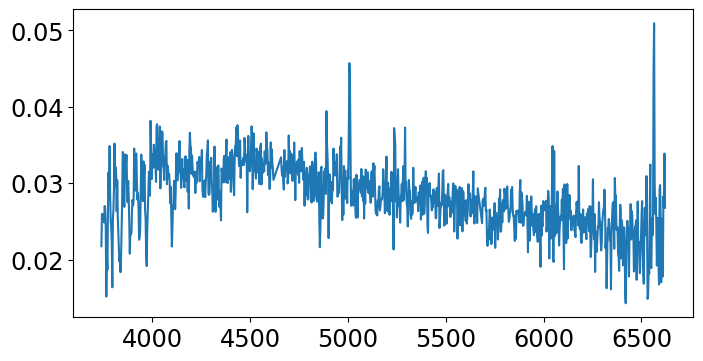

In [36]:
plt.plot(the_sed.wave,the_sed.flux)

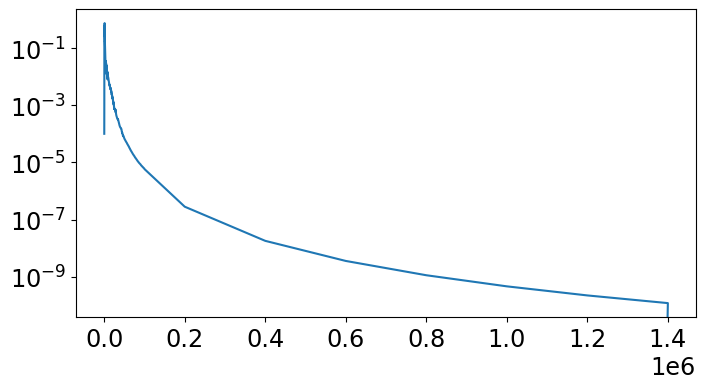

In [37]:
#plt.plot(arr[:,0],arr[:,1])
plt.plot(the_sed2.wave,the_sed2.flux)
#plt.xlim(arr[:,0].min(),arr[:,0].max())
filetag
plt.yscale("log")

In [38]:
filename

'SPEC160.txt'

In [39]:
    name_file=i_tmp+ext+'_BC.txt' # BC spectra sans extinction
    spec=SED(path_BC+name_file)

NameError: name 'i_tmp' is not defined